# HOML - Chapter 9: Unsupervised Learning - Gaussian Mixtures 

## Exercise 12

Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset's dimensionality (e.g., use PCA, preserving 99% of the variance).

Use the model to generate some new faces (using the sample() method), and visualize them (if you used PCA, you will need to use its inverse_transform() method).

Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the score_samples() method for normal images and for anomalies).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's start by loading the Olivetti faces dataset.

In [2]:
from sklearn.datasets import fetch_olivetti_faces

olvti = fetch_olivetti_faces()

In [3]:
print(olvti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

Just to briefly summarize the dataset, there are 40 different classes and 400 total different images, meaning that there are 10 images per person. Since the images are 64 x 64, each image has a dimensionality of 4096. The pictures were taken from different perspectives, during different times of day, and with varying expressions and light levels.  



Next, we'll need to split the dataset into training, validation, and test sets.
We'll use stratified sampling because the dataset is rather small and we want to ensure that we have the same number of images per person per set. 

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split 40 randomly chosen test images from the dataset, choosing one per class using stratified sampling
ss_splt = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=99)
train_val_idx, test_idx = next(ss_splt.split(olvti.data, olvti.target))
X_train_val = olvti.data[train_val_idx]
y_train_val = olvti.target[train_val_idx]
X_test = olvti.data[test_idx]
y_test = olvti.target[test_idx]

In [5]:
# From the remaining 360 images, randomly choose 80, two per class, using stratified sampling
ss_splt = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=99)
train_idx, val_idx = next(ss_splt.split(X_train_val, y_train_val))
X_train = X_train_val[train_idx]
y_train = y_train_val[train_idx]
X_val = X_train_val[val_idx]
y_val = y_train_val[val_idx]

In [6]:
# Confirm that the shape of each set is correct
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


We'll now use PCA to reduce the dimensionality, while preserving 99% of the variance, as the author recommends. This should substantially speed up the training process. As we did in exercise 10, we'll include a graph of how many dimensions are necessary to preserve 95% and 99% of the variance. 

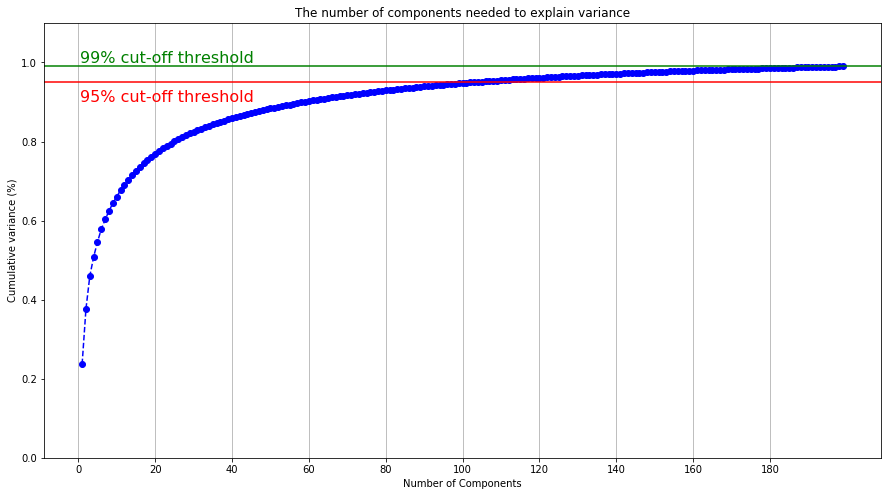

In [7]:
# Plotting variance against dimensions
# Code borrowed from: https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(0.99).fit(X_train)
plt.rcParams["figure.figsize"] = (15,8)

fig, ax = plt.subplots()
xi = np.arange(1, 200, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 200, step=20)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.90, '95% cut-off threshold', color = 'red', fontsize=16)

plt.axhline(y=0.99, color='g', linestyle='-')
plt.text(0.5, 0.999, '99% cut-off threshold', color = 'green', fontsize=16)

ax.grid(axis='x')
plt.show()

In [8]:
# Fit PCA to the training, validation, and test dataset
pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

Now, let's fit the Gaussian mixture model to our reduced training set.

In [9]:
# Import Gaussian mixture and fit to training set
from sklearn.mixture import GaussianMixture

gauss = GaussianMixture(n_components=40, random_state=99, n_init=10)
y_pred = gauss.fit_predict(X_train_pca)

We can see which cluster each instance is predicted to belong to.

In [10]:
# Hard clustering with predict()
y_pred

array([25,  2, 36, 34,  2, 26, 28, 34, 15, 38, 39, 10,  7, 18,  2, 20,  3,
       29, 21, 34,  5, 16, 13, 27, 11,  9, 38, 24, 10, 12,  7, 26, 26, 21,
       26, 39, 13,  2, 31, 39, 36,  5, 27, 11, 27,  9, 28, 13, 24, 26, 12,
       32,  1, 22,  1, 36, 31, 24, 19,  6, 18,  5,  1, 14, 13, 20, 15,  7,
       18, 22,  7,  7, 16, 15,  0, 22, 30, 17, 11, 27,  5, 38, 27, 34, 24,
       19, 39,  8, 32,  7,  9, 29, 25, 19, 11, 26,  7, 38,  7, 11, 26,  9,
        8, 19, 28, 14,  7, 20, 24,  4, 27, 11, 17,  5,  6,  3, 35, 24, 18,
        5, 24, 12, 15, 20,  8, 26, 25,  7, 18, 29, 29,  8, 26, 23, 21, 26,
        4, 34, 17, 38, 17,  8, 18, 15, 11,  9, 38, 33, 20, 23,  7, 36, 14,
       21, 11, 25,  1, 20, 33, 26, 13, 20, 26, 12, 26,  8, 32,  9, 33, 19,
       38, 17,  1, 16, 11,  8, 11, 14,  9, 10, 34, 24,  9, 15,  6, 24,  0,
       23, 10, 19,  1, 11, 26, 21, 29, 17, 31, 11, 19,  8,  9,  7, 30, 21,
       25, 35, 19, 27, 29, 19, 11, 33,  8, 29,  6, 19, 39,  6, 16, 27,  7,
       37,  4, 11, 24,  6

Predict_proba(), however, is an instance of soft clustering and will tell us the probablity that a an instance belongs to a given cluster. Below, we won't get much information from the arrays given the number of components and instances.

In [11]:
# Soft clustering with predict_proba()
gauss.predict_proba(X_train_pca)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Going beyond the scope of the problem briefly, let's look at the weights, means, and covariances. The weights tell us the weight assigned to each of our 40 components. All of them are well below one, and none of them stand out. 

In [12]:
# Weights of each component
gauss.weights_

array([0.025     , 0.03571429, 0.025     , 0.03571429, 0.04285714,
       0.03928571, 0.025     , 0.04642857, 0.03571429, 0.00714286,
       0.02142857, 0.01071429, 0.02142857, 0.01785714, 0.03928571,
       0.01428571, 0.05714286, 0.03214286, 0.01785714, 0.01785714,
       0.01785714, 0.04285714, 0.01071429, 0.02142857, 0.025     ,
       0.00714286, 0.025     , 0.01428571, 0.02142857, 0.01071429,
       0.01428571, 0.02857143, 0.03928571, 0.02857143, 0.01785714,
       0.02857143, 0.02142857, 0.03214286, 0.01071429, 0.01428571])

The means_ attribute gives us the mean of each mixture component, while covariances_ gives the covariance of each mixture component, and it's dependent on the covariance type. In this case, the covariance type is 'full', the default value, meaning that each component has its own general covariance matrix. 

In [13]:
gauss.means_

array([[-1.62435165e-01, -2.89641217e+00, -2.88930363e+00, ...,
         4.61923991e-02,  7.49715950e-03, -2.89173701e-02],
       [-5.45771408e+00,  1.54276299e+00, -4.32396967e-01, ...,
         7.16061275e-03,  6.36676686e-03, -1.37089863e-02],
       [ 9.08800704e+00, -3.72203127e-01, -3.41103240e+00, ...,
        -1.14313106e-02, -8.36464151e-03, -2.28263190e-02],
       ...,
       [ 3.26638138e+00, -2.84300473e+00,  9.37482980e-01, ...,
        -2.10367105e-02, -3.41980395e-02,  9.97471809e-03],
       [-2.54549805e+00,  2.12736638e+00,  2.36197567e+00, ...,
        -1.50697697e-02, -4.06385735e-02, -1.22860280e-02],
       [-9.26046740e-01, -1.57315036e+00,  1.74688369e-01, ...,
        -1.27859442e-02, -8.87618063e-03,  1.44602846e-02]])

In [14]:
gauss.covariances_

array([[[ 4.83320297e-01, -2.48165168e-01,  3.47630930e-01, ...,
         -1.15934687e-02, -2.78144541e-02, -1.53205412e-02],
        [-2.48165168e-01,  1.79826252e+00,  6.24011192e-01, ...,
          3.73324356e-02,  8.68132884e-03, -6.65387910e-03],
        [ 3.47630930e-01,  6.24011192e-01,  8.16198635e-01, ...,
          2.00364126e-02, -2.01556207e-03,  3.95073349e-03],
        ...,
        [-1.15934687e-02,  3.73324356e-02,  2.00364126e-02, ...,
          1.90030612e-02, -1.20856347e-02,  2.06456114e-02],
        [-2.78144541e-02,  8.68132884e-03, -2.01556207e-03, ...,
         -1.20856347e-02,  1.96797350e-02, -1.01576746e-02],
        [-1.53205412e-02, -6.65387910e-03,  3.95073349e-03, ...,
          2.06456114e-02, -1.01576746e-02,  2.67829307e-02]],

       [[ 1.19231186e+00, -3.30669044e-01,  4.04256798e-01, ...,
         -1.82639261e-02, -6.62185901e-02, -3.11135301e-02],
        [-3.30669044e-01,  1.63130977e+00,  1.44814757e+00, ...,
          5.23004759e-03, -5.03250975e

We can also check to see if the algorithm converged and, if so, in how many iterations. In this case, it did converge (meaning that it found an optimal solution) and it only took two iterations. 

In [15]:
# Check whether algorithm converged. 
gauss.converged_

True

In [16]:
# How many iterations required for convergence
gauss.n_iter_

2

Next, we're asked to create some new faces using the sample() method. Since we used PCA to reduce the dimensionality, we'll need to also use inverse_transform() to restore the information from the reduction. 

In [17]:
# A function to plot faces, borrowed from the author.
def plot_faces(faces, labels, n_cols=5):
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face.reshape(64, 64), cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

We'll create 40 new faces. Since GMM is generative, we can new grab instances from it (which are ordered by cluster index) using the sample method. A generative model allows us to create new random data that's similar to out input. Thus, for each of the faces, the sample() method allows us to generate a new random data distribution that fits that particular instance.

In [18]:
# Create 40 new faces using the sample() method  
faces_reduced, y_faces = gauss.sample(40)
gen_faces = pca.inverse_transform(faces_reduced)

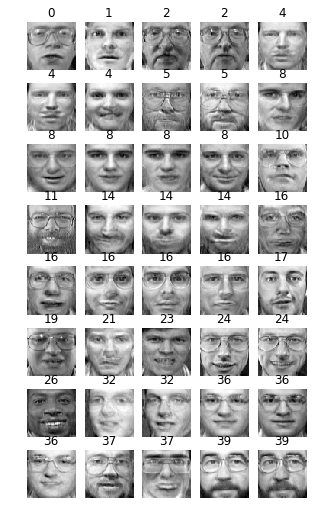

In [19]:
# Plot the new faces
plot_faces(gen_faces, y_faces)

Many of the faces look very similar to our original faces, but there are several that are distorted. This likely due to having used PCA reduced data that then had to be inverse transformed. The generative step was done on a smaller number of components than the original dataset. This reduced distribution was then inverse transformed not only from missing information, but information that had a new random distribution. 

Finally, we're asked to trasnform some images by rotating, flipping, and darkening them in order to detect any anomalies. We're then asked to compare the output of the score_samples() method between the original images and the modified images. score_samples() gives us the log of the probability density function of the model at a given location. The higher the value, the greater the density.  

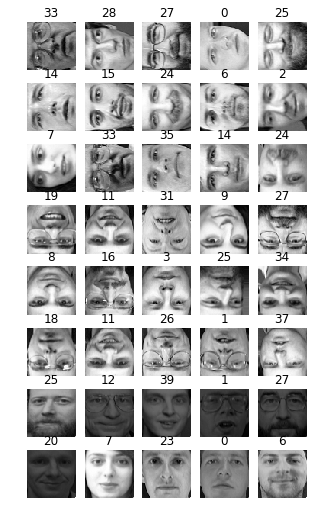

In [20]:
# Rotate, flip, and darken images by borrowing a little code from the author;  

rotate = np.transpose(X_train[36:50].reshape(-1, 64, 64), axes=[0, 2, 1])
rotate = rotate.reshape(-1, 64*64)
y_rotate = y_train[36:50]
    
flip = X_train[191:207].reshape(-1, 64, 64)[:, ::-1]
flip = flip.reshape(-1, 64*64)
y_flip = y_train[191:207]
    
darken = X_train[101:111].copy()
darken[:, 1:-1] *= 0.25
darken = darken.reshape(-1, 64*64)
y_darken = y_train[101:111]
    
X_mod_faces = np.r_[rotate, flip, darken]
y_mod = np.concatenate([y_rotate, y_flip, y_darken])

plot_faces(X_mod_faces, y_mod)

In [21]:
# Use PCA on the modified faces so that they have the same number of components as the non-modified PCA faces. 
X_mod_faces_pca = pca.transform(X_mod_faces)

In [22]:
# Density values of the modified images
gauss.score_samples(X_mod_faces_pca)

array([-2.21249285e+07, -4.81997647e+07, -3.36090840e+07, -6.04941353e+07,
       -3.93393922e+07, -2.92287424e+07, -4.21096624e+07, -2.44533001e+07,
       -3.95582381e+07, -2.46807483e+07, -3.39141969e+07, -2.80551555e+07,
       -4.59819907e+07, -2.64354577e+07, -3.24819067e+07, -3.72348731e+07,
       -5.68644870e+07, -3.65040346e+07, -5.87664789e+07, -5.02963592e+07,
       -4.02101959e+07, -4.35639388e+07, -3.13319622e+07, -4.89590647e+07,
       -4.91149175e+07, -4.90239344e+07, -5.87001462e+07, -4.82192473e+07,
       -2.96862433e+07, -3.31332922e+07, -1.40469007e+08, -1.32061981e+08,
       -1.24847157e+08, -1.43081180e+08, -1.38056318e+08, -1.58421875e+08,
       -1.27024288e+08, -1.40080262e+08, -1.19904883e+08, -1.23857000e+08])

In [23]:
# Density values of the original training images
gauss.score_samples(X_train_pca[100:200])

array([1074.72049313, 1110.35522494, 1111.00006992, 1132.19792033,
       1140.17352433, 1163.99404984, 1120.66310834, 1146.94549024,
       1132.13315742, 1118.29774845, 1146.47009688, 1074.72049205,
       1120.66311048, 1132.89882839, 1178.18495704, 1118.99761873,
       1140.17352313, 1147.32432867, 1124.67222124, 1132.89882853,
       1132.13315634, 1141.3254759 , 1148.52730385, 1146.94549217,
       1178.18495704, 1074.72049175, 1140.24343214, 1120.66311193,
       1148.83309362, 1132.898826  , 1154.61385335, 1118.29774762,
       1074.72049722, 1170.4334852 , 1155.31393805, 1125.33306303,
       1146.94549024, 1118.99761756, 1097.57679919, 1140.47003462,
       1097.57679544, 1170.3633023 , 1124.67222159, 1148.52730473,
       1104.87005331, 1125.33306521, 1140.47003356, 1111.00006959,
       1146.94549133, 1170.4334851 , 1120.66311179, 1102.92963975,
       1163.99404926, 1097.57679653, 1097.5768025 , 1140.24343184,
       1104.87002659, 1156.54111477, 1125.33306225, 1074.72051

As we can see, the score_samples values are drastically different between the original training images and the modified images, making it highly likely that the former would be treated as anomalies. 